# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 classes of food).

Our goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning)

Our baseline to beat is 50.76% accuracy across 101 classes

## Creating helper functions

In previous notebooks, we've created a series of helper function to do different tasks, let's download and import them

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

##  101 Food Classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the `image_data_modification` notebook

In [2]:
# Unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [3]:
# Setup directories
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [4]:
# How many images/class in our dataset
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\donuts'.
There are 0 directories and 250 images in '101_food_class

In [7]:
# Setup our data loaders 
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              image_size=IMG_SIZE,
                                                                              batch_size=BATCH_SIZE,
                                                                              label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              label_mode="categorical",
                                                              shuffle=False) # don't shuffle test data for prediction analysis                                                                                                                                                                                                                                                         

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [9]:
# Create checkpoint callback
checkpoint_path="101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True)

In [12]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation=tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
],name="data_augmentation")

In [13]:
# Build a headless model (no top layers) Functional EfficientNetB0 model

# Input shape of the data
input_shape=(224,224,3)

# Create a frozen base model
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create layers
inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

# Construct model
model=tf.keras.Model(inputs,outputs)        

In [14]:
# Get a summary of the model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [17]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model 
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)), # validate on only 15% of the data
                                           callbacks=[checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 116s 436ms/step - loss: 3.2035 - accuracy: 0.3133 - val_loss: 2.3757 - val_accuracy: 0.4725
Epoch 2/5
237/237 [==============================] - 83s 349ms/step - loss: 1.9558 - accuracy: 0.5607 - val_loss: 1.9356 - val_accuracy: 0.5273
Epoch 3/5
237/237 [==============================] - 77s 325ms/step - loss: 1.5658 - accuracy: 0.6350 - val_loss: 1.7846 - val_accuracy: 0.5474
Epoch 4/5
237/237 [==============================] - 72s 302ms/step - loss: 1.3362 - accuracy: 0.6845 - val_loss: 1.6932 - val_accuracy: 0.5630
Epoch 5/5
237/237 [==============================] - 69s 291ms/step - loss: 1.1725 - accuracy: 0.7250 - val_loss: 1.6381 - val_accuracy: 0.5673


In [20]:
# Evaluate on the whole test dataset
feature_extraction_results=model.evaluate(test_data)

790/790 [==============================] - 99s 125ms/step - loss: 1.4689 - accuracy: 0.6116


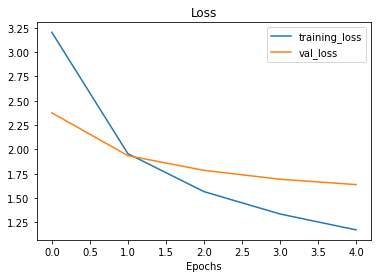

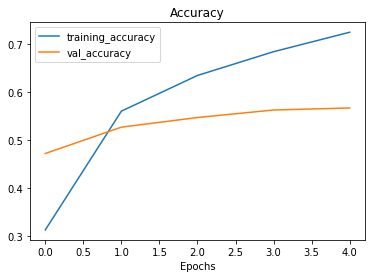

In [21]:
# Let's look at the loss curves
plot_loss_curves(history_all_classes_10_percent)

**Note**: It appears that our model is overfitting (performing too well on the training data and not generalizing to unseen data)

## Fine-tuning

In [22]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer but the last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [33]:
# Recompile the model with lower learning_rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [27]:
# What layers in the model are trainable
for layer in model.layers:
    print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [29]:
# Check which layers are trainabale in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [34]:
# Fine tune for another 5 epochs
# model has already done 5 epochs, total number of epochs we're after (5+5 = 10)
fine_tune_epochs = 10

# Refit the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)))


Epoch 5/10
237/237 [==============================] - 78s 304ms/step - loss: 0.9232 - accuracy: 0.7650 - val_loss: 1.6133 - val_accuracy: 0.5789
Epoch 6/10
237/237 [==============================] - 65s 275ms/step - loss: 0.8012 - accuracy: 0.7856 - val_loss: 1.6485 - val_accuracy: 0.5675
Epoch 7/10
237/237 [==============================] - 66s 280ms/step - loss: 0.7152 - accuracy: 0.8132 - val_loss: 1.6331 - val_accuracy: 0.5712
Epoch 8/10
237/237 [==============================] - 65s 275ms/step - loss: 0.6545 - accuracy: 0.8280 - val_loss: 1.6591 - val_accuracy: 0.5704
Epoch 9/10
237/237 [==============================] - 64s 269ms/step - loss: 0.5864 - accuracy: 0.8536 - val_loss: 1.6435 - val_accuracy: 0.5702
Epoch 10/10
237/237 [==============================] - 62s 262ms/step - loss: 0.5343 - accuracy: 0.8673 - val_loss: 1.6745 - val_accuracy: 0.5749


In [35]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results=model.evaluate(test_data)

790/790 [==============================] - 98s 124ms/step - loss: 1.4292 - accuracy: 0.6255


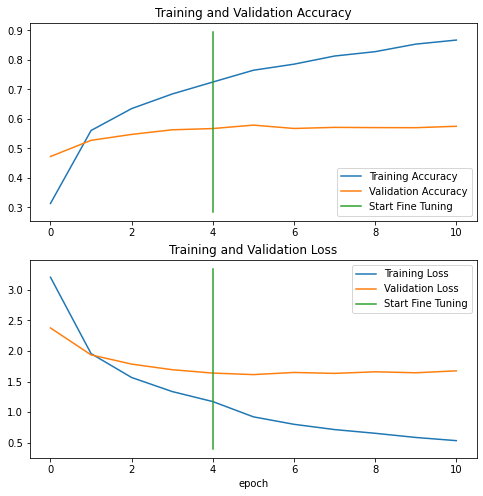

In [36]:
compare_historys(history_all_classes_10_percent,history_all_classes_10_percent_fine_tune)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [38]:
# Save our fine-tuned model
model.save("G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/101_food_classes_10_percent_saved_big_dog_model\assets


INFO:tensorflow:Assets written to: G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/101_food_classes_10_percent_saved_big_dog_model\assets


In [40]:
# Load an evaluated model
loaded_model=tf.keras.models.load_model("G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/101_food_classes_10_percent_saved_big_dog_model")

In [41]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data)

790/790 [==============================] - 105s 131ms/step - loss: 1.4292 - accuracy: 0.6255


In [42]:
# The results from oour loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.429176926612854, 0.625544548034668]

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them, and then later find out which predictions were the "most" wrong

In [43]:
# Unzip the data
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model=tf.keras.models.load_model("G:/UMass/Courses/Year_4 (2022)/TensorFlowDeveloperLocal/TensorFlow-Developer-Course/06_101_food_class_10_percent_saved_big_dog_model")

In [46]:
# Evaluate the loaded model
results_downloaded_model=model.evaluate(test_data)

790/790 [==============================] - 103s 129ms/step - loss: 1.8027 - accuracy: 0.6078
